In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight

from sklearn.metrics import classification_report, confusion_matrix
import zipfile, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(tf.__version__)


2.10.1


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:", len(gpus))
else:
    print("No GPUs available.")

Available GPUs: 1


In [3]:
base_dir = 'chest'
train_dir = 'chest/train'
test_dir = 'chest/test'
val_dir = 'chest/val'
os.listdir(base_dir)

['test', 'train', 'val']

Preview of Training Images:


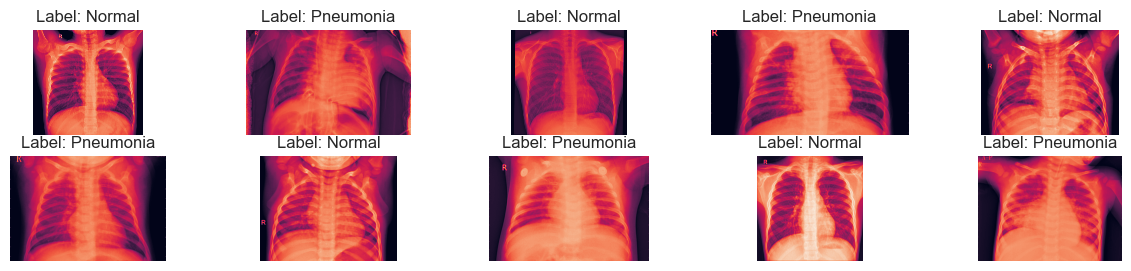

Preview of Validation Images:


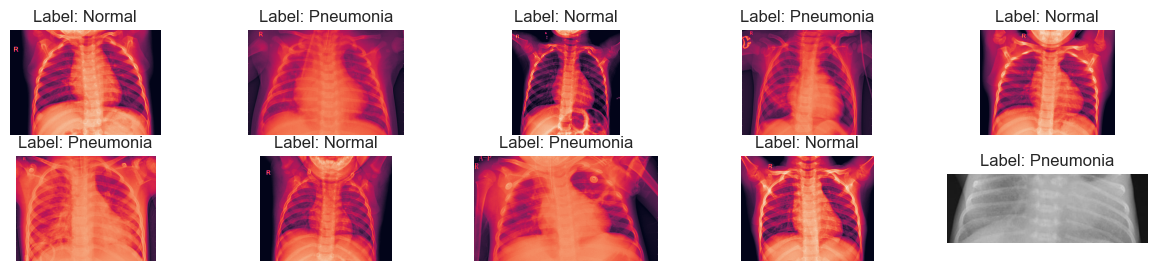

In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Function to preview images directly from a directory
def preview_images_from_directory(directory, class_labels, num_images=5):
    class_names = os.listdir(directory)

    plt.figure(figsize=(15, 3))
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpeg')]
        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        for i, image_file in enumerate(selected_images):
            plt.subplot(len(class_names), num_images, len(class_names) * i + class_names.index(class_name) + 1)
            img_path = os.path.join(class_path, image_file)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(f"Label: {class_labels[class_names.index(class_name)]}")
            plt.axis('off')

    plt.show()

# Define class labels for binary classification
class_labels_binary = ["Normal", "Pneumonia"]

# Preview images from the training directory
print("Preview of Training Images:")
preview_images_from_directory(train_dir, class_labels_binary)

# Preview images from the validation directory
print("Preview of Validation Images:")
preview_images_from_directory(val_dir, class_labels_binary)


In [5]:
img_width, img_height = 224, 224
batch_size = 256

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)



Found 4204 images belonging to 2 classes.
Found 1052 images belonging to 2 classes.


Preview of Training Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


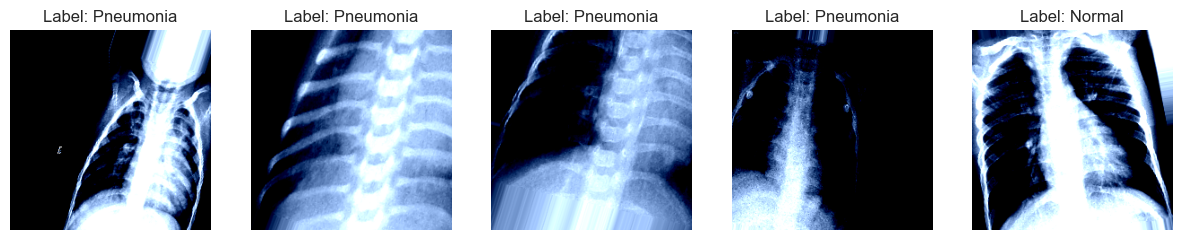

Preview of Validation Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


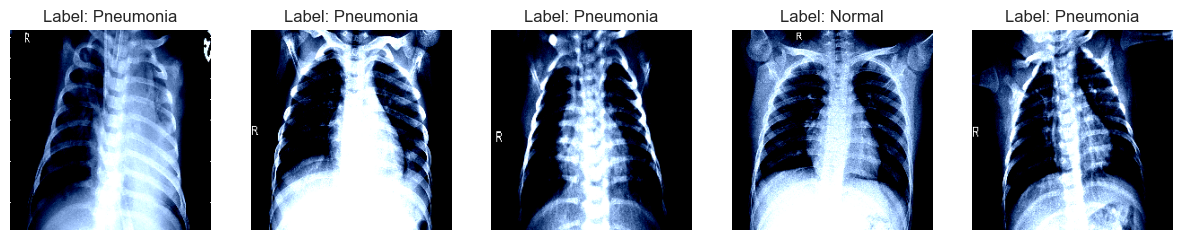

In [6]:
# Function to preview images from a data generator with class labels
def preview_images(generator, class_labels, num_images=5):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Map numeric labels to class names
    class_names = [class_labels[int(label)] for label in labels]

    # Display the images with labels
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[i]}")
        plt.axis('off')
    plt.show()

# Define class labels for binary classification
class_labels_binary = ["Normal", "Pneumonia"]

# Preview images from the training generator
print("Preview of Training Images:")
preview_images(train_generator, class_labels_binary)

# Preview images from the validation generator
print("Preview of Validation Images:")
preview_images(val_generator, class_labels_binary)


Number of samples in training set: 4204
Number of samples in validation set: 1052


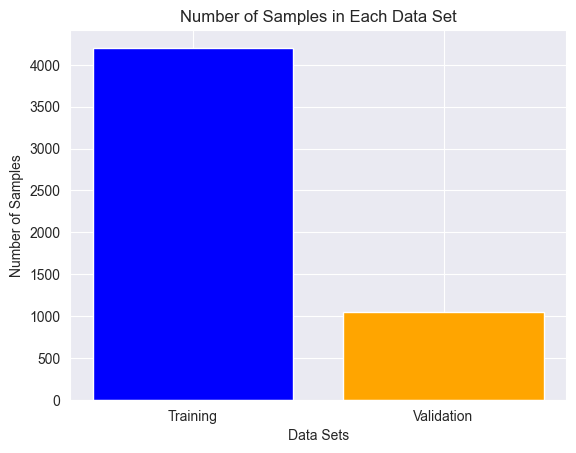

In [7]:
# Display the number of samples in each set
print("Number of samples in training set:", len(train_generator.classes))
print("Number of samples in validation set:", len(val_generator.classes))

# Visualize the number of samples in each set with a bar chart
sets = ['Training', 'Validation']
counts = [len(train_generator.classes), len(val_generator.classes)]

plt.bar(sets, counts, color=['blue', 'orange'])
plt.xlabel('Data Sets')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Data Set')
plt.show()


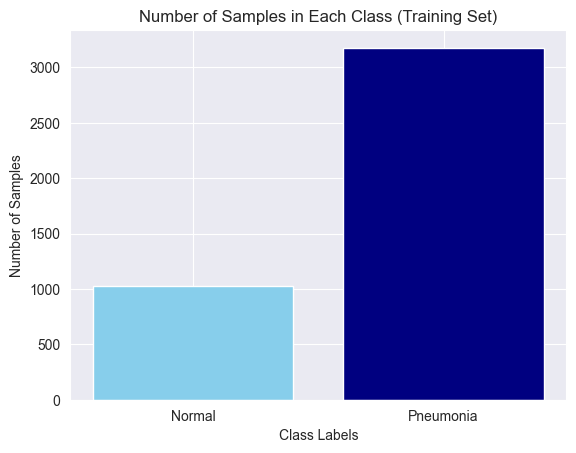

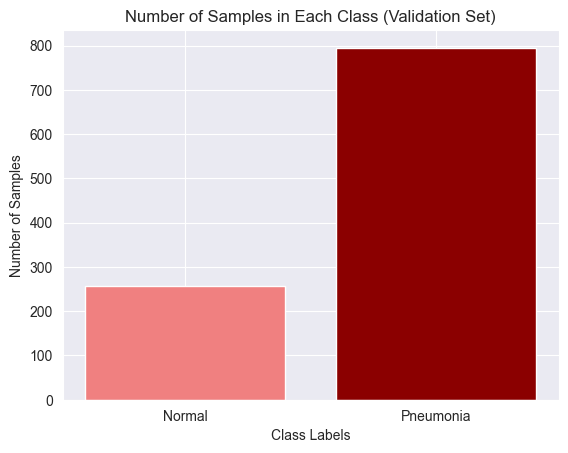

In [8]:
# Display the number of samples in each class within the training set
train_class_counts = np.bincount(train_generator.classes)
train_class_labels = ['Normal', 'Pneumonia']

plt.bar(train_class_labels, train_class_counts[:len(train_class_labels)], color=['skyblue', 'navy'])
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class (Training Set)')
plt.show()

# Display the number of samples in each class within the validation set
val_class_counts = np.bincount(val_generator.classes)
val_class_labels = ['Normal', 'Pneumonia']

plt.bar(val_class_labels, val_class_counts[:len(val_class_labels)], color=['lightcoral', 'darkred'])
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class (Validation Set)')
plt.show()

In [9]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 2.0487329434697856, 1: 0.6614222781623663}

In [10]:
densenet201 = DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in densenet201.layers:
    layer.trainable = False

x = densenet201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
pred = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=densenet201.input, outputs=pred)

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', save_best_only=True, mode='max', verbose=1)

In [12]:
epochs=50

hist = model.fit(train_generator,
                 epochs=epochs,
                 validation_data=val_generator,
                 callbacks=[early_stopping, reduce_lr, model_checkpoint],
                 class_weight=class_weight_dict
)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 3.7090 - binary_accuracy: 0.8192
Epoch 1: val_binary_accuracy improved from -inf to 0.82700, saving model to best_model.h5
17/17 [==============================] - 98s 4s/step - loss: 3.7090 - binary_accuracy: 0.8192 - val_loss: 2.7175 - val_binary_accuracy: 0.8270 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 2.1104 - binary_accuracy: 0.8951
Epoch 2: val_binary_accuracy improved from 0.82700 to 0.85932, saving model to best_model.h5
17/17 [==============================] - 76s 4s/step - loss: 2.1104 - binary_accuracy: 0.8951 - val_loss: 1.7240 - val_binary_accuracy: 0.8593 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.4337 - binary_accuracy: 0.9025
Epoch 3: val_binary_accuracy improved from 0.85932 to 0.86882, saving model to best_model.h5
17/17 [==============================] - 76s 4s/step - loss: 1.4337 - binary_accuracy: 0.9025 - val_loss: 1.2

In [13]:
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc}')

5/5 [==============================] - 10s 2s/step - loss: 0.3352 - binary_accuracy: 0.9183
Test accuracy: 0.9182509779930115


In [14]:
hist_= pd.DataFrame(hist.history)
hist_

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,3.709005,0.819220,2.717462,0.826996,0.001000
1,2.110443,0.895100,1.724019,0.859316,0.001000
2,1.433728,0.902474,1.280153,0.868821,0.001000
3,1.114157,0.904377,1.058990,0.879278,0.001000
4,0.945114,0.915557,0.904274,0.903042,0.001000
5,0.826734,0.921741,0.860409,0.877376,0.001000
6,0.746339,0.924120,0.759018,0.896388,0.001000
7,0.679973,0.932445,0.783628,0.865019,0.001000
8,0.642439,0.927926,0.767056,0.854563,0.001000
9,0.603856,0.925071,0.680686,0.878327,0.001000


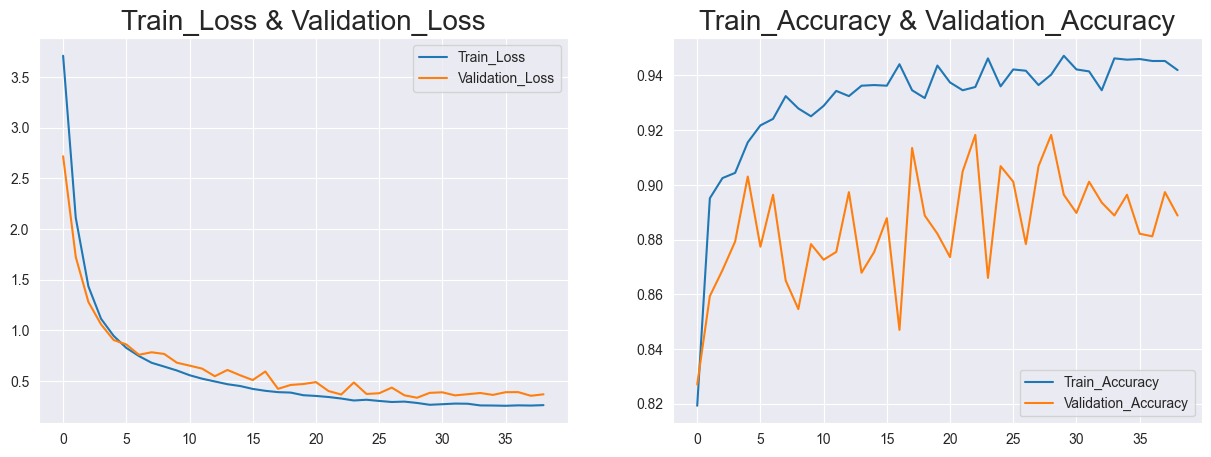

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['binary_accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_binary_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [16]:
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 600 images belonging to 2 classes.


In [17]:
y_pred = model.predict(test_generator)

3/3 [==============================] - 15s 4s/step


In [18]:
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

In [19]:
classification_rep = classification_report(y_true, y_pred_binary, target_names=['Normal', 'Pneumonia'])
confusion_mat = confusion_matrix(y_true, y_pred_binary)

print("Classification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", confusion_mat)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.99      0.95       300
   Pneumonia       0.99      0.90      0.94       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600


Confusion Matrix:
 [[297   3]
 [ 29 271]]


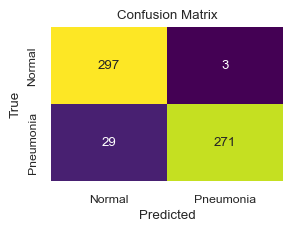

In [20]:
plt.figure(figsize=(3, 2))
sns.set(font_scale=0.8)
sns.heatmap(confusion_mat, annot=True, cmap='viridis', cbar=False, fmt='d', 
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
model.save('pneumonia_densenet201v2BatchSize256.h5')

1/1 [==============================] - 5s 5s/step
chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg
Image classified as Pneumonia
[0.98069525]


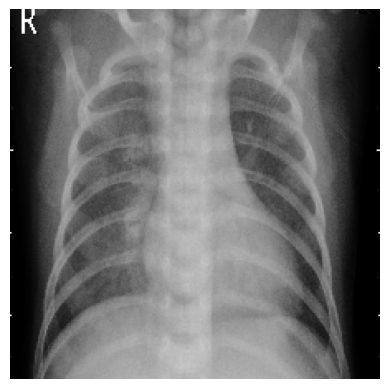

In [22]:
# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = fn
img = image.load_img('chest/val/PNEUMONIA/person74_virus_135.jpeg', target_size=(224,224,3))

imgplot = plt.imshow(img)
plt.axis('off')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
images = np.vstack([x])

classes = model.predict(images)
print('chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg')
if classes[0] > 0.5:
  print('Image classified as Pneumonia')
else:
  print('Image classified as Normal')
print(classes[0])